In [1]:
import re
import pandas as pd
import os
import pickle
import seaborn as sns
import numpy as np
import sys
sys.path.append("/Users/jiahang/Documents/dagma/src/dagma/")
import utils
import matplotlib.pyplot as plt
import scipy
import utils_dagma
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score
from copy import deepcopy
import fdr_control

In [2]:
def fdr_log(Z, W_true, n_jobs):
    W_true = true_data['W_true']
    
    from joblib import Parallel, delayed
    from tqdm import tqdm
    from copy import deepcopy
    fdr=0.2
    num_feat = 100
    est_type = 'tau+'
    n_jobs = 1
    
    print(f"==============================")
    print(f"expected FDR {fdr}")
    
    t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
    
    T_T_true = np.abs(W_true)
    mask = (T_T_true > 0.)
    T_T_true[mask], T_T_true[~mask] = 1, 0
    
    fdr_est_last = 1.
    t_last = np.inf
    
    def _get_t(t_list: list):
        t_last = np.inf
        fdr_est_last = None
        for t in reversed(t_list):
            if t < 0.:
                break
            if est_type == 'tau':
                fdr_est = ((Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
            else:
                fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
            
            T_T = Z.copy()
            mask = (T_T >= t)
            T_T[mask], T_T[~mask] = 1, 0
            perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
            fdr_true, power = perf['fdr'], perf['tpr']
            print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")
    
            if fdr_est <= fdr:
                t_last = t
                fdr_est_last = fdr_est
        return t_last, fdr_est_last
        
    interval = len(t_list) // n_jobs
    intervals = [(j * interval, (j+1) * interval) for j in range(n_jobs - 1)]
    intervals.append(
        ((n_jobs-1) * interval, len(t_list))
    )
    res1 = []
    res1 = Parallel(n_jobs=n_jobs)(
            delayed(_get_t)(
                t_list[interval[0]:interval[1]]
            ) for interval in intervals
        )
    
    
    res = np.array([list(_res) for _res in res1 if not np.isinf(_res[0]) and _res[1] is not None])
    if len(res) > 0: # otherwise, no edge being selected
        t_last = res[:, 0].min()
        t_last_idx = np.argmin(res[:, 0])
        fdr_est_last = res[t_last_idx, 1]
    
    mask = (Z >= t_last)
    Z[mask], Z[~mask] = 1, 0
    T_T = Z
    
    perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
    fdr_true, power = perf['fdr'], perf['tpr']
    
    if utils_dagma.is_dag(T_T):
        print("W_est is DAG")
    else:
        print("W_est is NOT DAG")
    print(f"expected fdr {fdr:.1f} | sel thresh {t_last:.4e} | "
          f"est fdr {fdr_est_last:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")
    print(f"==============================")

In [3]:
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v11/v100_600_normX_sym1/'
with open(path + f'X/X_1.pkl', 'rb') as f:
    true_data = pickle.load(f)
X = true_data['X']
W_true = true_data['W_true']
B_true = (W_true != 0)

In [4]:
rng = np.random.default_rng(0)

# dag_8

In [183]:
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_option_5_PLS_normX_sym1_grnboost2/W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W = pickle.load(f)['W_est']
Z = np.abs(W[:100, :100]) - np.abs(W[100:, :100])

In [184]:
_Z = deepcopy(Z)

In [185]:
d=100
selectors = rng.binomial(1, 0.5, [d, d])
cnt=0
for i in range(d):
    for j in range(i, d):
        if _Z[i, j] > _Z[j, i]:
            _Z[j, i] = 0.
            cnt+=1
        elif _Z[i, j] < _Z[j, i]:
            _Z[i, j] = 0.
            cnt+=1
        else:
            if selectors[i, j] == 1:
                _Z[j, i] = 0.
            else:
                _Z[i, j] = 0.

Text(0.5, 1.0, '100 * 600 | Z distribution | PLS, all other nodes fit j')

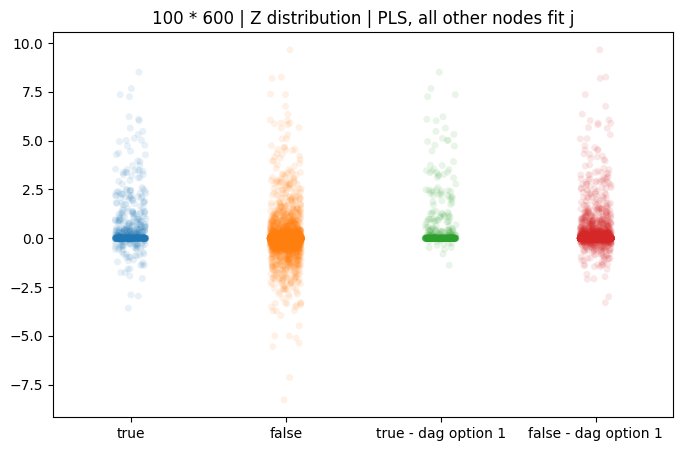

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
data = {
    'true': Z[B_true].flatten(), 
    'false': Z[~B_true].flatten(), 
    'true - dag option 1': _Z[B_true].flatten(),
    'false - dag option 1': _Z[~B_true].flatten(),
}
sns.stripplot(data, alpha=0.1, ax=ax)
ax.set_title("100 * 600 | Z distribution | PLS, all other nodes fit j")

# dag_9

In [192]:
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_option_5_PLS_normX_sym1_grnboost2/W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z = np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100])

In [193]:
W = np.abs(W_full[:d, :d])
selectors = np.random.binomial(1, 0.5, [d, d])
cnt = 0
for i in range(d):
    for j in range(i, d):
        if W[i, j] > W[j, i]:
            W_full[j, i] = 0.
            W_full[j+d, i] = 0.
            cnt += 1
        elif W[i, j] < W[j, i]:
            W_full[i, j] = 0.
            W_full[i+d, j] = 0.
            cnt += 1
        else:
            if selectors[i, j] == 1:
                W_full[j, i] = 0.
                W_full[j+d, i] = 0.
            else:
                W_full[i, j] = 0.
                W_full[i+d, j] = 0.
W = W_full[:, :d]

In [194]:
_Z = np.abs(W[:100, :100]) - np.abs(W[100:, :100])

Text(0.5, 1.0, '100 * 600 | Z distribution | PLS, all other nodes fit j')

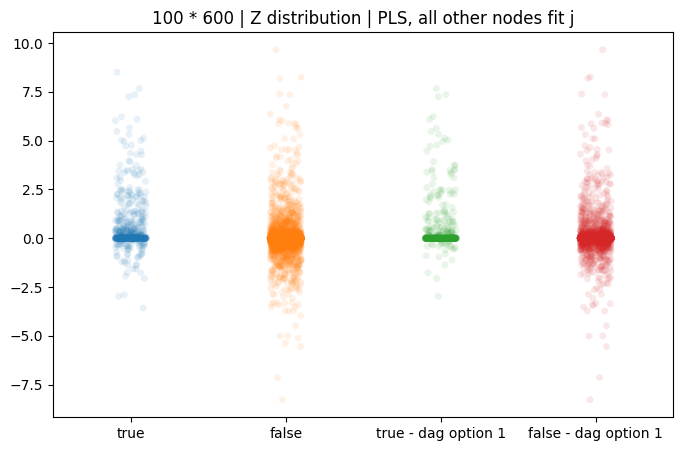

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
data = {
    'true': Z[B_true].flatten(), 
    'false': Z[~B_true].flatten(), 
    'true - dag option 1': _Z[B_true].flatten(),
    'false - dag option 1': _Z[~B_true].flatten(),
}
sns.stripplot(data, alpha=0.1, ax=ax)
ax.set_title("100 * 600 | Z distribution | PLS, all other nodes fit j")

# dag_10_0

In [5]:
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_option_5_PLS_normX_sym1_grnboost2/W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z = np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100])


mask = fdr_control.extract_dag_mask(Z, 4)
_Z = Z.copy()
Z[~mask] = 0.
assert (_Z[_Z < 0.] == Z[Z < 0.]).all()

In [6]:
(Z > 0.).sum()

1181

In [7]:
fdr_log(Z.copy(), W_true, 1)

expected FDR 0.2
thresh 9.6508 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 8.5015 | est fdr 0.5000 | true fdr 0.5000 | true power 0.0017
thresh 8.2700 | est fdr 1.0000 | true fdr 0.5000 | true power 0.0017
thresh 8.2531 | est fdr 0.6667 | true fdr 0.6667 | true power 0.0017
thresh 8.1862 | est fdr 0.5000 | true fdr 0.7500 | true power 0.0017
thresh 7.6681 | est fdr 0.4000 | true fdr 0.6000 | true power 0.0033
thresh 7.3544 | est fdr 0.3333 | true fdr 0.6667 | true power 0.0033
thresh 7.3533 | est fdr 0.2857 | true fdr 0.5714 | true power 0.0050
thresh 7.2503 | est fdr 0.2500 | true fdr 0.5000 | true power 0.0067
thresh 7.1287 | est fdr 0.3750 | true fdr 0.5000 | true power 0.0067
thresh 6.7561 | est fdr 0.3333 | true fdr 0.5556 | true power 0.0067
thresh 6.3543 | est fdr 0.3000 | true fdr 0.6000 | true power 0.0067
thresh 6.2227 | est fdr 0.2727 | true fdr 0.5455 | true power 0.0083
thresh 6.0938 | est fdr 0.2500 | true fdr 0.5000 | true power 0.0100
thresh 6.0626 | e